# **Customer Clustering**
- The objective of this task is to cluster customers of a shopping mall to understand customers better in order to retain said customers.

Questions to be answered:

- How to perform customer segmentation using unsupervised machine learning algorithm in Python?
- Describe the characteristics of each customer cluster.
- Which group of customer is the most valuable to the shopping mall so that the shopping mall should do something to retain them?

In [58]:
from typing import Sequence, Tuple
from itertools import combinations, chain
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score

df = pd.read_csv("Customer_Dataset.csv")

## **Data Exploration**

In [59]:
df.head()

,CustomerID,Gender,Age,Income (k$),How Much They Spend
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [60]:
rows, cols = df.shape
print("There are {} rows and {} features in the data.".format(rows, cols))

There are 200 rows and 5 features in the data.


In [61]:
df.describe(include='all')

,CustomerID,Gender,Age,Income (k$),How Much They Spend
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


From the `.head` function, we find that:

|Columns|	Descriptions|
| :---: | :---: |
|CustomerId| Unique identifier for each customer |
|Gender| Gender of each customer |
|Age| Age of customers |
|Annual Income (k$)| Annual Income of the customer in thousands|
|Spending Score (1-100)| Score assigned by the mall based on customer behavior and spending nature |

In total, there are 4 numerical columns, `CustomerID` , `Age` , `Income (k$)` and `How Much They Spend` and only 1 categorical column, `Gender`

## **Exploratory Data Analysis**

Firstly, I would like to edit some of the feature names so that they are easier to use and less confusing for me.

In this section, I would like to:
- Perform univariate/bivariate analysis
- Check the distribution of numerical data
- Check the count of categorical data
- Identify columns that require scaling
- Find any correlations between features/ Any clusters formed

In [62]:
new_names = { 
    'CustomerID': 'cust_id',
    'Gender': 'gender',
    'Age': 'age', 
    'Income (k$)': 'salary(k$)',
    'How Much They Spend': 'amt_spent',
}
df.rename(columns = new_names, inplace=True)
df.head()

,cust_id,gender,age,salary(k$),amt_spent
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


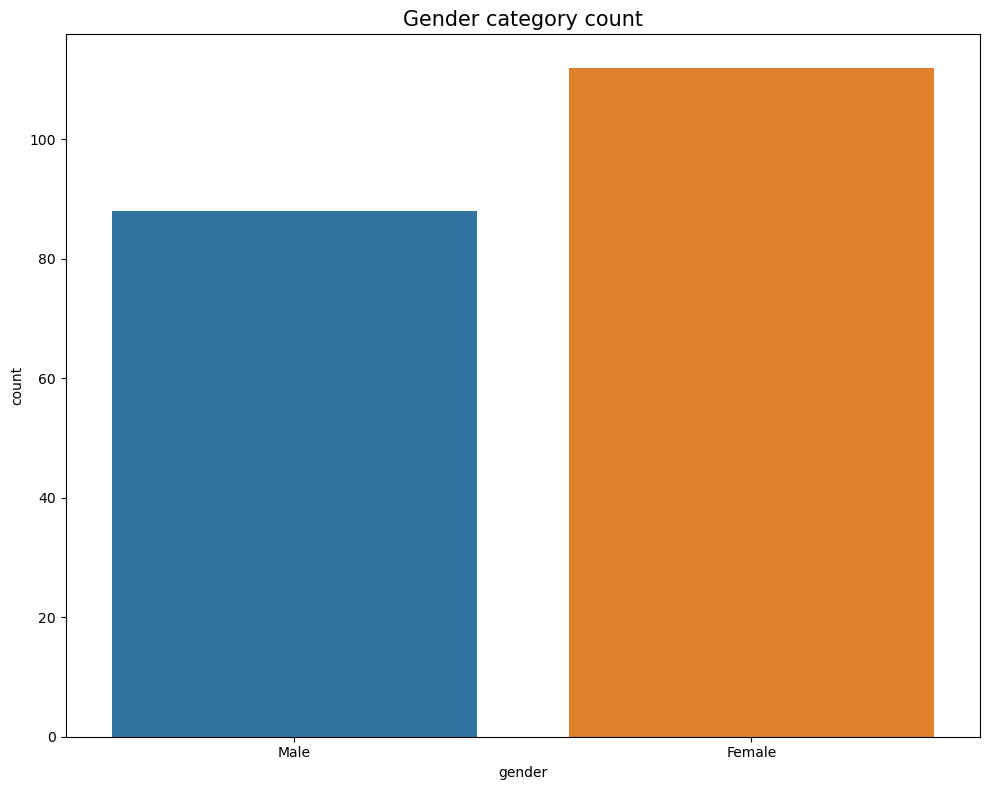

In [63]:
# Categorical count

fig = plt.figure(tight_layout = True, figsize = (10, 8))
ax = sns.countplot(x = df['gender'], data = df)
ax.set_title(f'Gender category count', fontsize=15)

plt.show()

#### **Data Distribution**

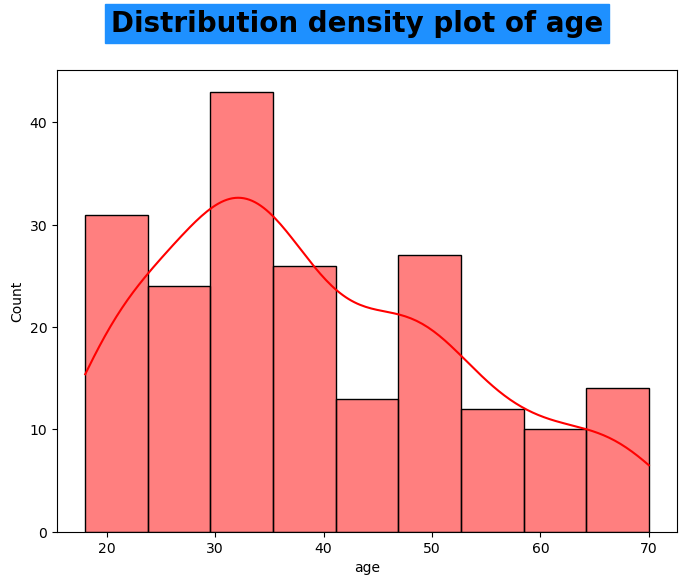

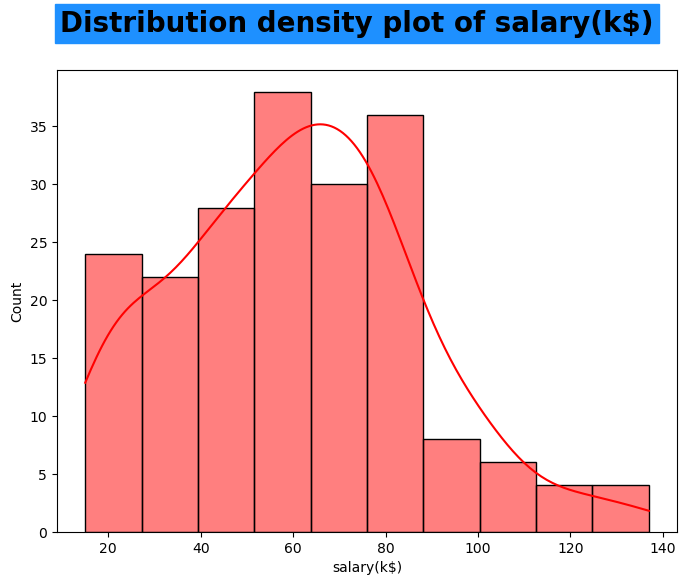

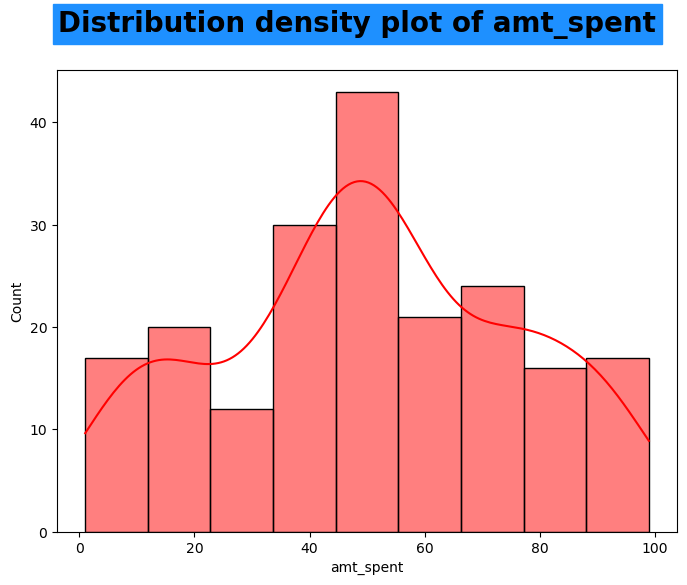

In [64]:
quant_features = ['age', 'salary(k$)', 'amt_spent']

for feature in quant_features:
  fig = plt.figure(figsize=(8,6))
  sns.histplot(data=df, x = feature, kde=True, color='red', alpha=0.5)

  fig.suptitle(f'Distribution density plot of {feature}',color='black',weight='bold',size=20, backgroundcolor= 'Dodgerblue')

  plt.show()

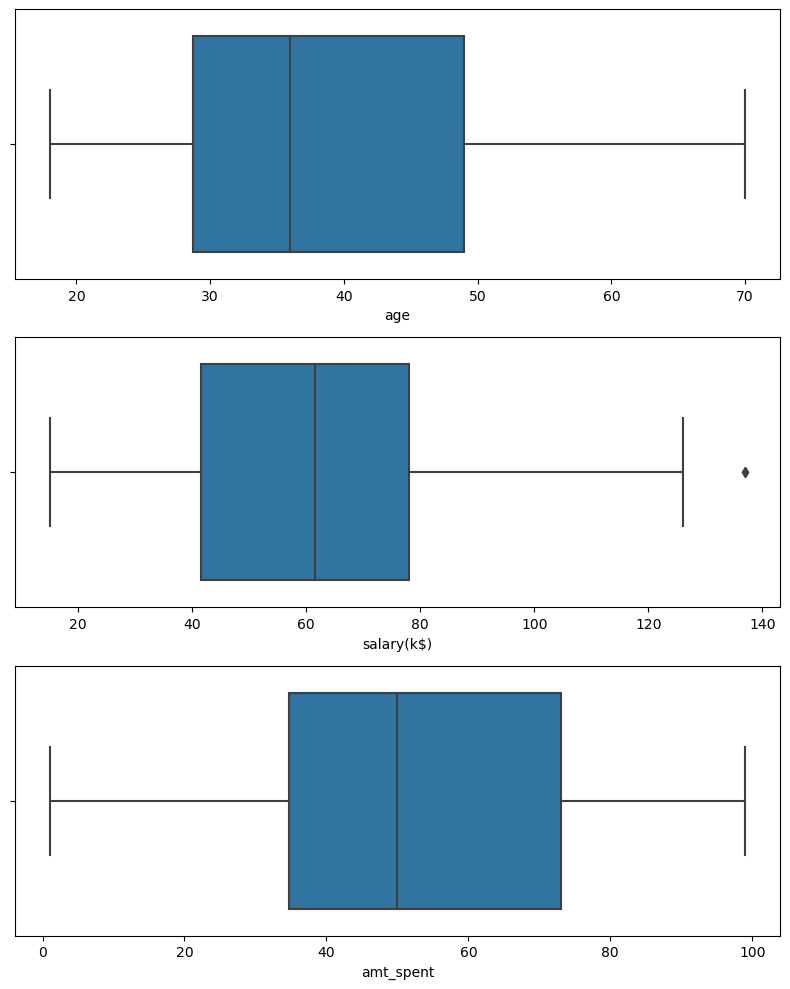

In [65]:
fig, ax = plt.subplots(len(quant_features), 1, figsize=(8, 10), tight_layout=True)
for idx, feature in enumerate(quant_features):
    sns.boxplot(data = df, x=feature, ax = ax[idx])
fig.show()

As we can see from the univariate analysis, all of the variables require normalising. `salary` and `age` is positively skewed while amt_spent actually has a quite similar distribution to gaussian distribution. I feel that there is no need to scale due to the fact that the range of each data is quite similar. 

From the boxplot, we can see that:

- The average:
    - Age is about 36
    - Salary is about $62000 a year
    - amt-spent from a range of 0-100 is 45
- There is only one outlier in all 3 features, which is salary.

#### **Pairplot**

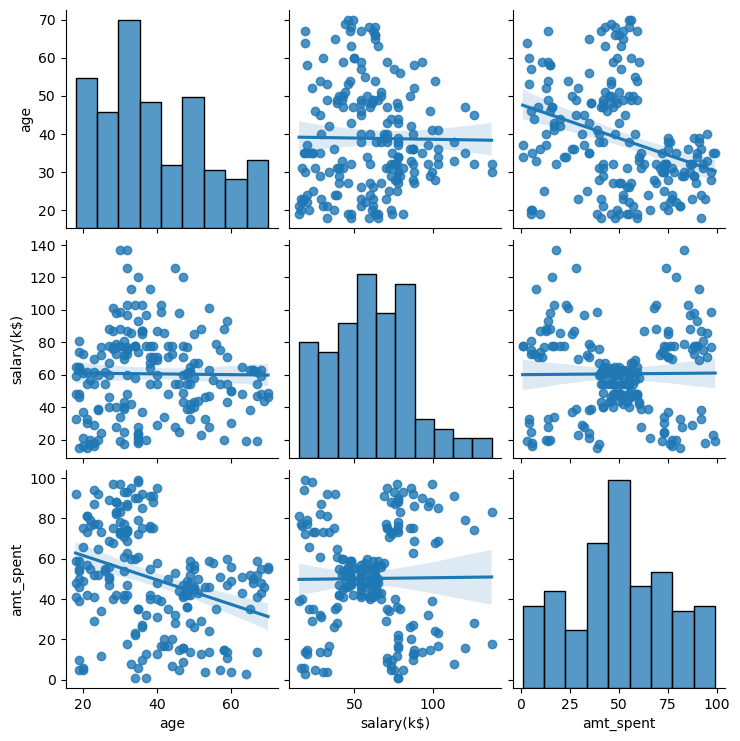

In [66]:
#Drop gender and cust id from df
df_num = df.drop(columns=['gender', 'cust_id'], axis=1)
sns.pairplot(df_num, kind='reg')

As we can see from the pairplot: 
- There are 5 natural clusters that appear between the amount spent and salary earnt
- We can also see that as the customers age increasing, the amount of money spent decreases.
- Apart from Age and Amount spent, there are no other significant relationships.
However to validify the last point, I will also plot a correlation plot.

In the next correlation plot, I will be using phi k as the correlation coefficient. It is better at identifying non linear relationships that may be available between different features. This identifies dependencies between each pair of variables better.

interval columns not set, guessing: ['age', 'salary(k$)', 'amt_spent']


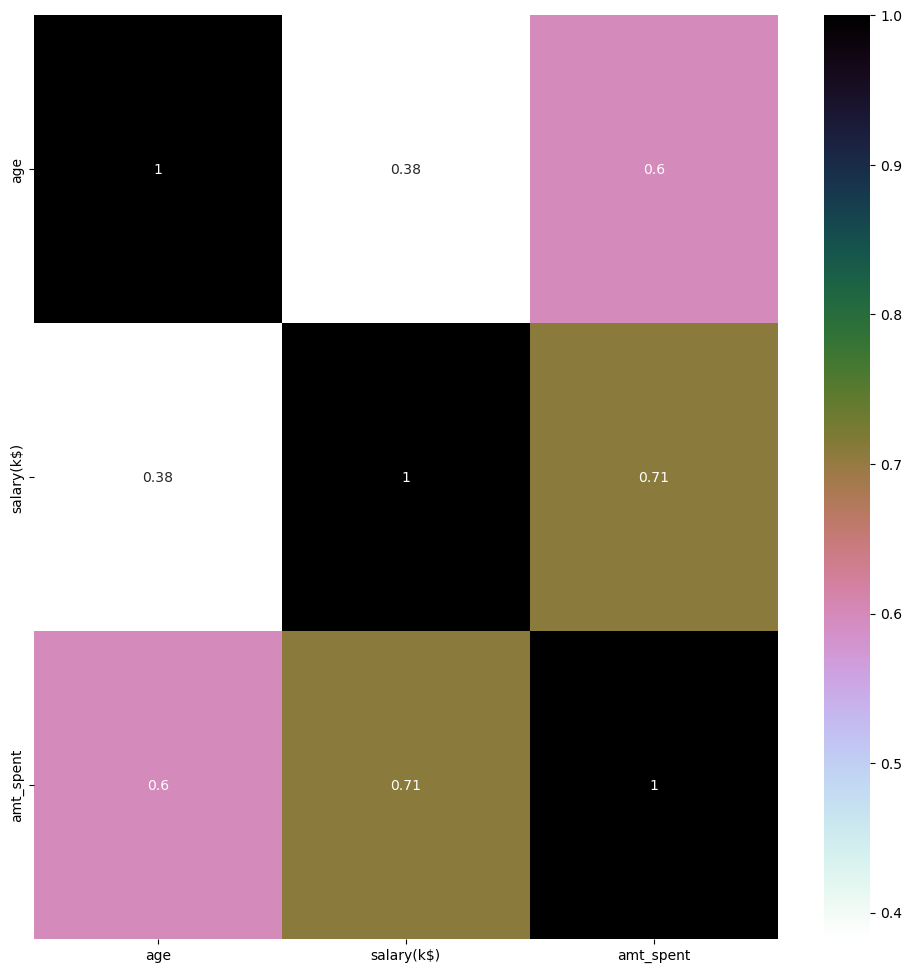

In [69]:
import phik
from phik.report import plot_correlation_matrix
from phik import report
from phik import resources, report

plt.figure(figsize=(12,12))
sns.heatmap(
    df_num.phik_matrix(),
    cmap="cubehelix_r",
    annot = True)
plt.show()